# PSP Visualization


## I.part - Data Mining
* First approach to get the data is to download whole set from original page(because it is government - is should release the data) but unfortunately the data are (for me) in really bad structure and the point of this semestral work was to try at least basic scraping tools.
* So, let's try another approach but at first we should get to know the data (I do personally see the data for second time or so..). The page with voting results itself has in url argument `g`, which seems to increment in next voting results pages. 
* So I created iteration from first voting id (`g` in url) to the last url, then on each page I will iterate over parties with help of BeautifulSoup(plus extract the title and session number from the heading). Firstly I tried to limit downloading by 1 second pause between requests but that was really slow so I made the pause half the second - it is still really slow but I leave that be.
* After several tries to scrape the data I realized that I need to save some partial results.So every session I scrape - I'll save into csv. In the meantime I can start to prepare the visualisation part and if the scraping part failed or other errors (e.g. pc shutdown) occured I could start downloading from the current position (which can save a lot of time and energy)
* But the speed of downloading was quite slow so I started inspecting why is that.I've developed this task on really old laptop so I did not suspect anything in the beginning but then I take `time` tool and make measurements.The outcome was that one page took 30 seconds so investigated further.And it turns up that appending into DataFrame is really slow - about 0,15 s which is not that bad but If I do it on every mp so every voting page  times 200 that would take 2 days to scrape about 7000 pages :D. I changed structure of data from `DataFrame` to regular array of dictionaries and after whole downloading I create `DataFrame` from scraped data.
* During downloading I've noticed some irregularities in data so I had to check data if the number of voting results corresponds to the correct number.

In [ ]:
# import all the neccessary libs
import requests
import time
from bs4 import BeautifulSoup
import pandas as pd

tmp = []

# vote_id
max_vote_id = 73901
min_vote_id = 67018

# iterate over all the votes within the range
for vote_id in range(min_vote_id, max_vote_id + 1):
    try: 
        # await for a while to prevent blocking from the provider
        time.sleep(0.5)
        start = time.time()
        
        # make http get request
        url= 'https://www.psp.cz/sqw/hlasy.sqw?g=' + str(vote_id)
        r = requests.get(url)
        
        # parse the document into the soup :)
        soup = BeautifulSoup(r.text, 'html.parser')

        # hack to extract title of voting procedure
        vote_title = ''.join(soup.find('h1').find('br').next_siblings)
        vote_description = soup.find('h1').next_element.strip().split(',')[0]

        # focus on the main part of the page (to prevent finding incorrect elements)
        soup_main = soup.find('div',{"id": "main-content"})

        # iterate over all the parties (+ remove first and last title - clear the data)
        for party in soup_main.find_all('h2',{"class": "section-title"})[1:-1]:
            # extract the name of the party
            party_name = party.span.find(text=True, recursive=False).split(sep=' ')[0]
            
            # iterate over all the member of parlaments of the current party
            for mp in party.findNext('ul'):
                # extract name and vote
           
                mp_name = mp.get_text().split(' ')[1].split('(')[0]
                mp_vote = mp.get_text().split(' ')[0]
                
                # create row object and then insert into dataframe
                row = {'Vote description': vote_description,'Vote Id': vote_id, 'Vote Title': vote_title, 'Party': party_name, 'MP': mp_name,'Vote': mp_vote}
                tmp.append(row) 
            
        # print the result and time of execution    
        end = time.time()    
        print(vote_description + ' ' + vote_title + ' ' + str(vote_id) + ' time: ' + str(end - start))
    except Exception as e: 
        print("exception", end=' ')
        print(e)

df = pd.DataFrame(tmp, columns=['Vote description', 'Vote Id', 'Vote Title', 'Party', 'MP', 'Vote'])

# export data
export_file = 'export.csv'
df.to_csv(export_file, index=False) 

print("export is done to " + export_file)

1. schůze Inf. o ustavení volební komise PS a volbě členů 67018 time: 0.5056350231170654
1. schůze Inf. o ustavení volební komise PS a volbě členů 67019 time: 1.5071866512298584
1. schůze  67020 time: 0.505239725112915
1. schůze Náv.na stanovení počtu čl. MIV 67021 time: 0.5364830493927002


In [1]:
 #visualisation part
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

min_vote_id = 67018
max_vote_id = 73901

# Bez násl. řádku někdy nefunguje vykreslování grafů v Jupyter noteboocích
%matplotlib inline 
import matplotlib
matplotlib.style.use('ggplot')

# load the data
df = pd.read_csv("export.csv")

# create partial data frames
df_a = df[df.Vote == "A"]
df_n = df[df.Vote == "N"]
df_z = df[df.Vote == "Z"]
df_0 = df[df.Vote == "0"]
df_m = df[df.Vote == "M"]


# tool to check valid count of downloaded data
#check_data = df.groupby("Vote description").count()
#check_data.MP = check_data.MP / 200 
#check_data.MP

## Attendance of whole parties
* first step is to prepare the data: set MP to 1 and Vote 1 if MP was present and registered to vote (not `Omluven` nor `Nepřihlášen`)
* then group by parties and sum the values - then in `MP` column there will be total number and in Vote column there would be only present and active mps so to the column `result` count percentage of each party
* then just sort the data and make a plot

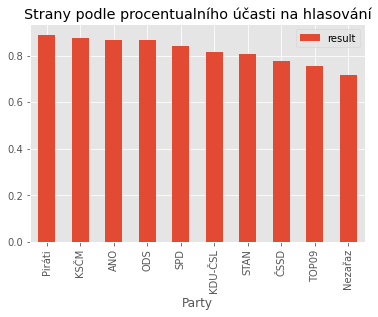

In [3]:
# prepare data
attendance_data = df.drop(columns=["Vote description", "Vote Id"])
attendance_data['MP'] = 1
attendance_data['Vote'] = attendance_data.Vote.apply(lambda x: 0 if x == "O" or x == "M" else 1)

# compute the data
attendance = attendance_data.groupby("Party").sum()

# normalize the numbers to total number of MPs
attendance['result'] = attendance.Vote / attendance.MP

# plot the result
attendance = attendance.drop(columns=['Vote', "MP"]).sort_values("result", ascending=False)
attendance.plot(kind='bar', title="Strany podle procentualního účasti na hlasování")

print()

* yet that does visualise only total percentage but not development of attendance
* so I prepared another graph about attendance in time
* Firstly, prepare data by choosing only present mps and drop redundant columns
* then compute number of present mps on each vote per party (put parties as columns)
* then present plot with development

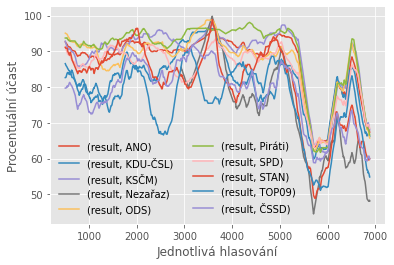

result                                                     \
Party           ANO KDU-ČSL       KSČM Nezařaz         ODS      Piráti   
Vote Id                                                                  
1        100.000000   100.0  93.333333     NaN  100.000000  100.000000   
2        100.000000   100.0  93.333333     NaN  100.000000  100.000000   
3        100.000000   100.0  93.333333     NaN  100.000000  100.000000   
4        100.000000   100.0  93.333333     NaN  100.000000  100.000000   
5        100.000000   100.0  93.333333     NaN  100.000000  100.000000   
...             ...     ...        ...     ...         ...         ...   
6880      51.282051    50.0  53.333333    50.0   47.826087   54.545455   
6881      51.282051    50.0  53.333333    50.0   47.826087   54.545455   
6882      51.282051    50.0  53.333333    50.0   47.826087   54.545455   
6883      51.282051    50.0  53.333333    50.0   47.826087   54.545455   
6884      50.000000    50.0  53.333333    50.0   47.826087   54.545455   

                                                    
Party           SPD        STAN       TOP09   ČSSD  
Vote Id                                             
1        100.000000  100.000000  100.000000  100.0  
2        100.000000  100.000000  100.000000  100.0  
3        100.000000  100.000000  100.000000  100.0  
4        100.000000  100.000000  100.000000  100.0  
5        100.000000  100.000000  100.000000  100.0  
...             ...         ...         ...    ...  
6880      57.894737   66.666667   42.857143   50.0  
6881      57.894737   66.666667   42.857143   50.0  
6882      57.894737   66.666667   42.857143   50.0  
6883      57.894737   66.666667   42.857143   50.0  
6884      57.894737   66.666667   42.857143   50.0  

[6879 rows x 10 columns]

In [39]:
# prepare data
attendance_in_time_data = df.drop(columns=["Vote Title", "Vote description"])
attendance_in_time_data['MP'] = 1
attendance_in_time_data['Vote'] = attendance_in_time_data.Vote.apply(lambda x: 0 if x == "O" or x == "M" else 1)
attendance_in_time_data['Vote Id'] = attendance_in_time_data['Vote Id'] - min_vote_id + 1


# make the computation
attendance_in_time = attendance_in_time_data.groupby(["Vote Id", "Party"]).sum()
attendance_in_time['result'] = attendance_in_time.Vote / attendance_in_time.MP * 100
attendance_in_time = attendance_in_time.drop(columns=["Vote", "MP"]).unstack('Party').reset_index().set_index('Vote Id')

# visualisation
attendance_in_time.rolling(500).mean().plot()
plt.legend(loc='lower left', frameon=False, ncol=2)
plt.ylabel('Procentuální účast')
plt.xlabel('Jednotlivá hlasování')
plt.show()

attendance_in_time

* this looks cool but the original graph had huge ups and downs so I used `rolling` to get mean value per 500 votings

## Attendance of each MPs
* prepare data by aggregating not-present and active MPs.(value `Omluven` or `Nepřihlášen`)
* then just group by parties and count lines, after that sort the values and plot the data 

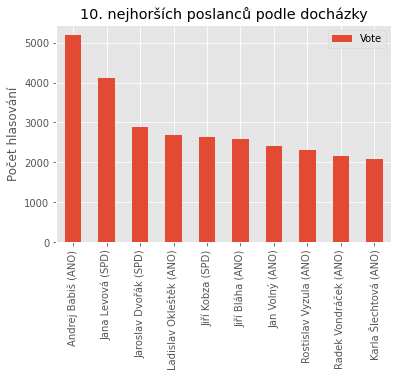

In [9]:
names = ["ANO", "SPD"]
# prepare data
attendance_mps_data = pd.concat([df_0, df_m])[["MP", "Vote", "Party"]]
attendance_mps_data = attendance_mps_data[attendance_mps_data.Party.isin(names)]
attendance_mps_data.MP = attendance_mps_data.MP + " (" + attendance_mps_data.Party + ")"
attendance_mps_data = attendance_mps_data.drop(columns=["Party"])

# get the computed data
attendance_mps = attendance_mps_data.groupby("MP").count().sort_values("Vote", ascending=False).head(10)

# make the visualisation
attendance_mps.plot(kind='bar', title="10. nejhorších poslanců podle docházky")
plt.xlabel('')
plt.ylabel('Počet hlasování')

print()

## Corellation between parties based on voting results
* first prepare the data: use only `A` values = MP voted yes.
* drop redundant columns, then group by Vote Id and Party to get  number of Yes votes per party per voting
* then unstack party to transform the matrix to get parties in column and vote ids in rows (plus fill NaN as zeroes)
* create correlation matrix and 
* when comes to `N` - do the same but with different data in the beggining

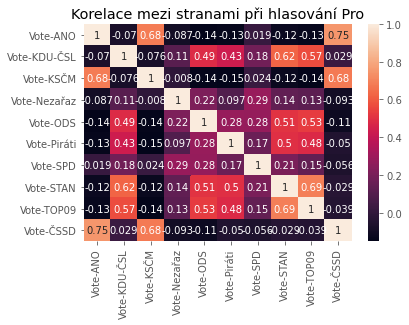

In [19]:
# prepare data
corr_df_data = df_n.drop(columns=['Vote description', 'Vote Title', 'MP'])

#compute the results
corr_matrix = corr_df_data.groupby(["Vote Id", "Party"]).count().unstack('Party').fillna(0).corr()

#visualize the output
sn.heatmap(corr_matrix, annot=True)
plt.xlabel('')
plt.ylabel('')
plt.title("Korelace mezi stranami při hlasování Pro")
plt.show()

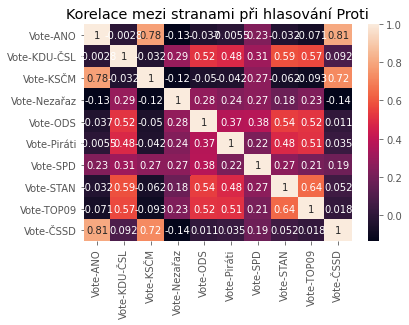

In [35]:
# prepare data
corr_df_data = df_a.drop(columns=['Vote description', 'Vote Title', 'MP'])

#compute the results
corr_matrix = corr_df_data.groupby(["Vote Id", "Party"]).count().unstack('Party').fillna(0).corr()

#visualize the output
sn.heatmap(corr_matrix, annot=True)
plt.xlabel('')
plt.ylabel('')
plt.title("Korelace mezi stranami při hlasování Proti")
plt.show()

## MPs that left a party or joined another party
* prepare the data by selecting Party and MP and then drop duplicates - so if MP will be represented more than once then he or she will be party migrant
* another practical step is to groupby by MP and count and filter out the mps that are represented only once
* then print out the migrants :)

In [21]:
# prepare the input data
party_to_party_migrants_data =  df[["Party", "MP"]].drop_duplicates()

#compute the result
party_to_party_migrants = party_to_party_migrants_data.groupby('MP').filter(lambda x: len(x) > 1).MP.drop_duplicates().reset_index(drop=True)

# print the result
print("List poslanců kteří změnili stranu během volebního období: ", end="")
print(*party_to_party_migrants.tolist(), sep=', ')

List poslanců kteří změnili stranu během volebního období: Václav Klaus, Zuzana Majerová, Marian Bojko, Tereza Hyťhová, Ivana Nevludová, Lubomír Volný, Jaroslav Foldyna


* but that does not say any about parties that lost or get new MPs 
* so I prepared another graph about parties' MPs count in time

Party    KDU-ČSL  KSČM  Nezařaz   ODS  Piráti   SPD  STAN  TOP09  ČSSD
Vote Id                                                               
1           10.0  15.0      NaN  25.0    22.0  22.0   6.0    7.0  15.0
2           10.0  15.0      NaN  25.0    22.0  22.0   6.0    7.0  15.0
3           10.0  15.0      NaN  25.0    22.0  22.0   6.0    7.0  15.0
4           10.0  15.0      NaN  25.0    22.0  22.0   6.0    7.0  15.0
5           10.0  15.0      NaN  25.0    22.0  22.0   6.0    7.0  15.0
...          ...   ...      ...   ...     ...   ...   ...    ...   ...
6880        10.0  15.0      6.0  23.0    22.0  19.0   6.0    7.0  14.0
6881        10.0  15.0      6.0  23.0    22.0  19.0   6.0    7.0  14.0
6882        10.0  15.0      6.0  23.0    22.0  19.0   6.0    7.0  14.0
6883        10.0  15.0      6.0  23.0    22.0  19.0   6.0    7.0  14.0
6884        10.0  15.0      6.0  23.0    22.0  19.0   6.0    7.0  14.0

[6879 rows x 9 columns]

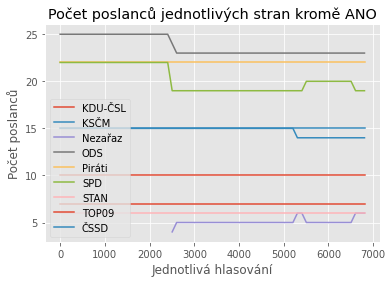

In [41]:
# Show time-based number of MPs per Party
time_based_number_mps_data = df[df.Party != "ANO"].drop(columns=["Vote Title", "Vote", "Vote description"])
time_based_number_mps_data['Vote Id'] = time_based_number_mps_data['Vote Id'] - min_vote_id + 1

# computation
time_based_number_mps = time_based_number_mps_data.groupby(["Vote Id", "Party"]).count().unstack('Party').reset_index().set_index('Vote Id')
time_based_number_mps.columns = time_based_number_mps.columns.droplevel(0)

# visualize
time_based_number_mps.iloc[::100, :].sort_index().plot()
plt.legend(loc='lower left')
plt.ylabel("Počet poslanců")
plt.xlabel('Jednotlivá hlasování')
plt.title("Počet poslanců jednotlivých stran kromě ANO")

time_based_number_mps

* the data are without ANO party - ANO has 78 MPs all the time - so it is irrelevant for this particular visualisation 
* another interesting information is about MPs that did not finish entire election period

In [36]:
left_or_join_mps = df[["Party", "MP"]].groupby("MP").count().sort_values("Party", ascending=True)
(x,y ) = df.groupby("Vote Id").count().shape

print("Poslanci, kteří nedosloužili celé volební období")
print(left_or_join_mps[left_or_join_mps.Party < x].rename(columns={ "Party": "Počet hlasování"}))

Poslanci, kteří nedosloužili celé volební období
                     Počet hlasování
MP                                  
Jaroslava Pokorná                 16
Jiří Hlavatý                      16
Martin Půta                       16
Irena Blažková                   332
Bohuslav Sobotka                 498
Robert Pelikán                   877
Martin Stropnický               1210
Vladimír Koníček                1546
Dan Ťok                         2464
Milan Chovanec                  2464
Petr Bendl                      3152
Ondřej Babka                    3152
František Navrkal               3392
Mikuláš Peksa                   3487
Radka Maxová                    3727
Veronika Vrecionová             3727
Iva Kalátová                    4415
Václav Votava                   4415
Marie Pěnčíková                 5333
Petr Venhoda                    5669
Monika Červíčková               6002
Roman Sklenák                   6381
Petr Vrána                      6547
Milan Pour                

## Parties' Unity during voting
* to get the most rebelious MPs we need to prepare data by marking  yes and no in numeric way, which allows us to do the sum later.
* we group data by vote and party and then sum the votes
* we create another helper column to hold the information about majority vote of the party
* we divide the data to A and N parts,  for each part we select the votes where party was not united and then merge them back
* to get real results we need to filter data - so we recreate column `Vote` and put there an opposite majority vote
* from the results we sort the worst one and visualize the rest

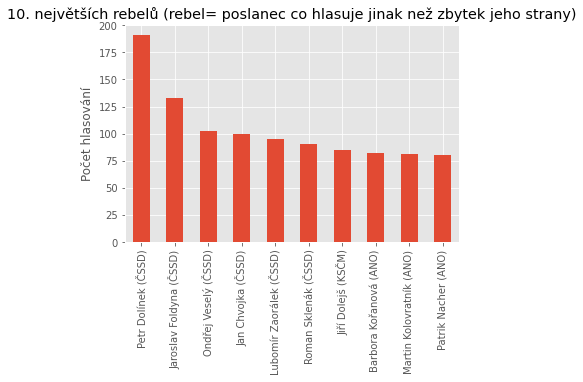

In [2]:

# prepare data
herd_vote_data = pd.concat([df_a, df_n])[["MP", "Vote", "Party", "Vote Id"]]
herd_vote_data.MP = herd_vote_data.MP + " (" + herd_vote_data.Party + ")"
herd_vote_data["Vote_A"] = herd_vote_data.Vote.apply(lambda x: 1 if x == "A" else 0)
herd_vote_data["Vote_N"] = herd_vote_data.Vote.apply(lambda x: 1 if x == "N" else 0)

# get get sum of votes per party per vote
herd_vote = herd_vote_data.groupby(["Vote Id","Party"]).sum().reset_index()

# create helper column - is column Vote_A a majority ? 
herd_vote['result'] = herd_vote["Vote_A"] > herd_vote["Vote_N"]

# divide data into two parts - A is majority and N is majority
herd_vote_n = herd_vote[herd_vote['result'] == False]
herd_vote_a = herd_vote[herd_vote['result'] == True]

# get all votes where parties had at least one vote opposite 
herd_vote_n_res = herd_vote_n[herd_vote_n["Vote_A"] > 0].drop(columns=['Vote_A', 'Vote_N', 'result'])
herd_vote_a_res = herd_vote_a[herd_vote_a["Vote_N"] > 0].drop(columns=['Vote_A', 'Vote_N', 'result'])

# add another helper column to mark the opposite of majority vote
herd_vote_n_res['Vote'] = "A"
herd_vote_a_res['Vote'] = "N"

# merge them together
herd_vote_res = pd.concat([herd_vote_n_res,herd_vote_a_res])

# stackoverflow magic :D 
# it takes data and transform them into tuples and then filter with them original values
# goal is to get mps that voted incorrectly (= against the party majority vote) 
tuples = [tuple(x) for x in herd_vote_res.to_numpy()]
rebel_mps = herd_vote_data[pd.Series(list(zip(df['Vote Id'], df['Party'], df['Vote']))).isin(tuples)]

# get count of rebel actions for every MP and then choose the 10 worst 
top_rebel_mps = rebel_mps.MP.value_counts().head(10)
top_rebel_mps.plot(kind='bar', title="10. největších rebelů (rebel= poslanec co hlasuje jinak než zbytek jeho strany)")
plt.ylabel("Počet hlasování")
print()

* in order to create visualisation of herd mentality of each party(herd mentality = all the MPs of the party vote same or substain) we need to modify data little bit
* we divide the data to get votings where the party voted-as-one and then merge them back
* then group them by party and count the occurences
* finally visualize the data :)

Party Vote
23         SPD    A
35        ČSSD    A
71         ANO    A
81     KDU-ČSL    A
357       ČSSD    A
...        ...  ...
60614      ANO    N
60641     KSČM    N
60676     ČSSD    N
60742      SPD    N
60792     ČSSD    N

[3584 rows x 2 columns]

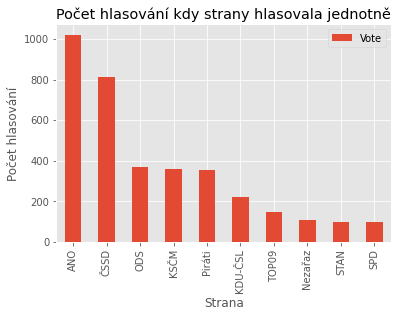

In [4]:
# get data where parties voted as one
herd_vote_n_res_party = herd_vote_n[herd_vote_n["Vote_A"] == 0].drop(columns=['Vote_A', 'Vote_N', 'result'])
herd_vote_a_res_party = herd_vote_a[herd_vote_a["Vote_N"] == 0].drop(columns=['Vote_A', 'Vote_N', 'result'])
herd_vote_res_party = pd.concat([herd_vote_n_res,herd_vote_a_res]).drop(columns=['Vote Id'])

# group the count per party and plot the result
herd_vote_res_party.groupby("Party").count().sort_values("Vote", ascending=False).plot(kind='bar', title='Počet hlasování kdy strany hlasovala jednotně')
plt.ylabel("Počet hlasování")
plt.xlabel("Strana")

herd_vote_res_party

In [38]:
parties = df.drop(columns=["Vote Title", "Vote description"])
parties.Vote = parties.Vote.apply(lambda x: 0 if x == "O" or x == "M" else 1)
parties.MP = 1

parties = pd.pivot_table(parties, values='Vote', index=['Vote Id'], columns='Party', aggfunc=np.sum)
parties["result"] = 0
parties["result", "ANO"] = 0 
parties["result", "SPD"] = 0
  
#for column in parties["MP"].columns:
#    print(column)
#    parties['result',column] = parties['Vote'][column] / parties['MP'][column]
        
#parties = parties.drop(columns=["MP", "Vote"]).unstack().reset_index()
#parties = pd.pivot_table(parties, values=0 , index=['Vote Id'], columns='Party', aggfunc=np.sum)
parties

ValueError: Names should be list-like for a MultiIndex